<a href="https://colab.research.google.com/github/miladasgari178/Drift_Detection_Machine_Learning/blob/main/Drift_Detection_GAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import inv
import math
import re
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/shiam/'
df = pd.read_csv('20160930_203718.csv')

Mounted at /content/gdrive
/content/gdrive/My Drive/shiam


In [ ]:
df.head(500)

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,49.7534,23.7184,233.2737,0.8993,0.2231,0.6365,1.1493,0.8483,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
1,0.309,0.0,55.8400,26.6200,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,9.4472,10.5769,13.6317,21.9829,16.1902,24.2780,31.1014,34.7193,31.7505,41.9167
2,0.618,0.0,55.8400,26.6200,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,33.0704,36.3160,42.5746,49.7495,31.7533,57.7289,53.6275,56.9212,47.8255,62.9436
3,0.926,0.0,55.8400,26.6200,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,58.3847,67.5130,68.0064,59.2824,36.7821,66.0832,66.8349,66.9695,50.3730,64.8363
4,1.234,0.0,55.8400,26.6200,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,71.7732,79.9474,79.8631,62.5385,39.6271,68.1441,62.0947,49.4614,52.8453,66.8445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,152.570,0.0,54.3300,26.5800,240.3827,0.1990,0.4607,0.5501,0.7433,5.3947,6.2541,3.7358,5.1647,36.1896,28.0132,40.4326,47.7312,36.4956,31.7505,47.2945
496,152.880,0.0,54.3300,26.5800,240.2346,0.2000,0.4537,0.5443,0.7291,5.0777,5.7716,3.5085,4.7817,37.7252,28.0132,40.6416,44.7674,35.7480,31.7505,47.0102
497,153.189,0.0,54.3300,26.5800,240.0869,0.2000,0.4472,0.5385,0.7151,4.8117,5.3664,3.3301,4.4760,39.6076,27.4403,40.6416,43.6563,36.3548,31.8817,48.0691
498,153.498,0.0,54.3300,26.5800,240.0243,0.1995,0.4411,0.5339,0.7026,4.5651,4.9990,3.1616,4.1594,35.6850,27.6287,39.6838,47.2109,35.1605,31.1729,47.0102


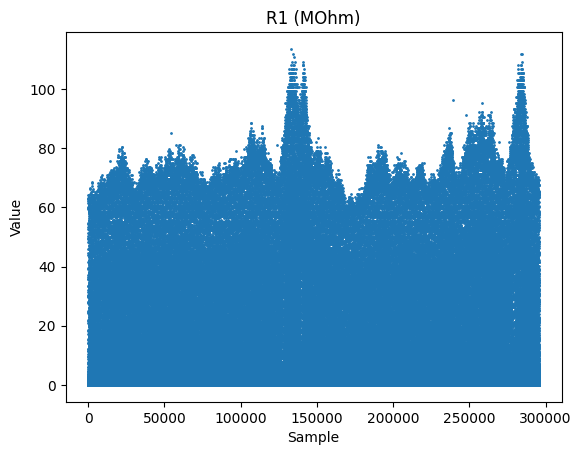

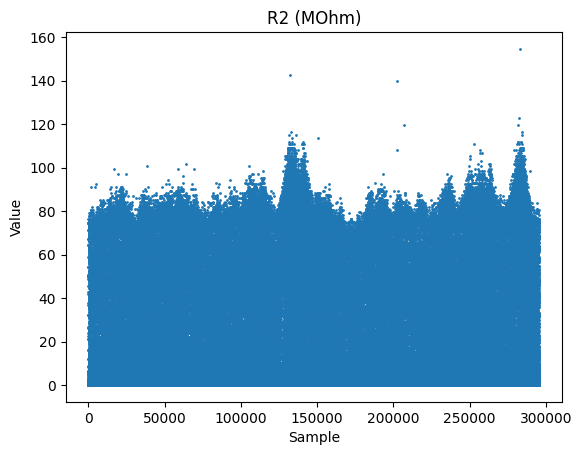

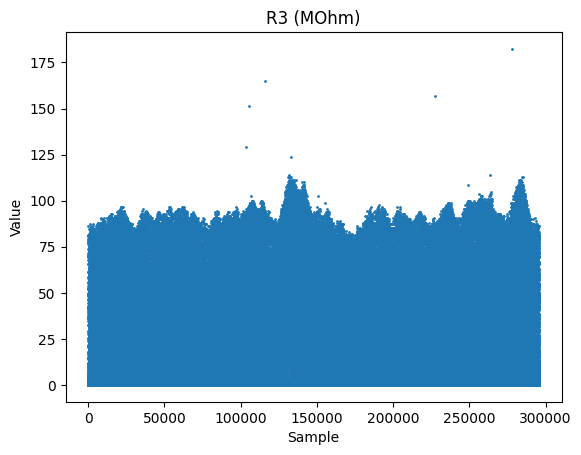

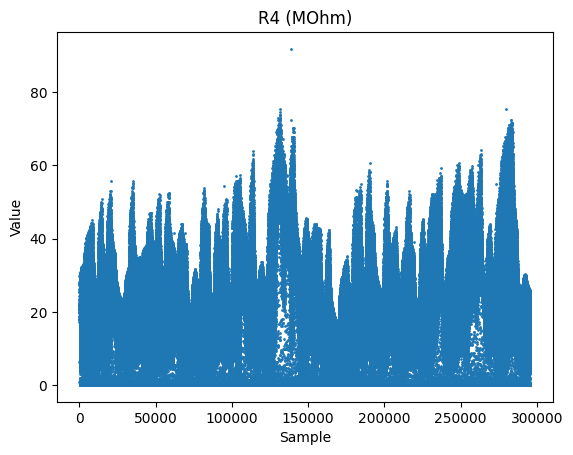

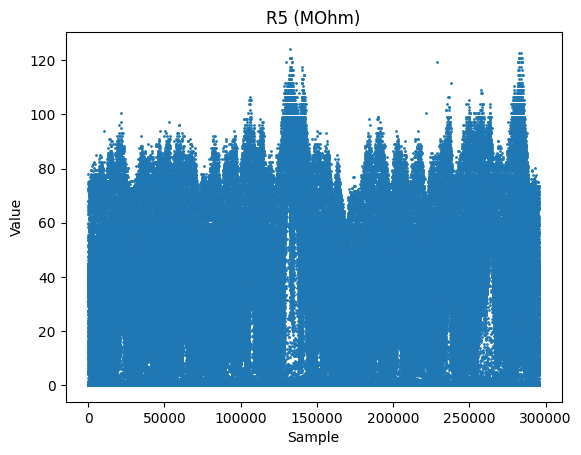

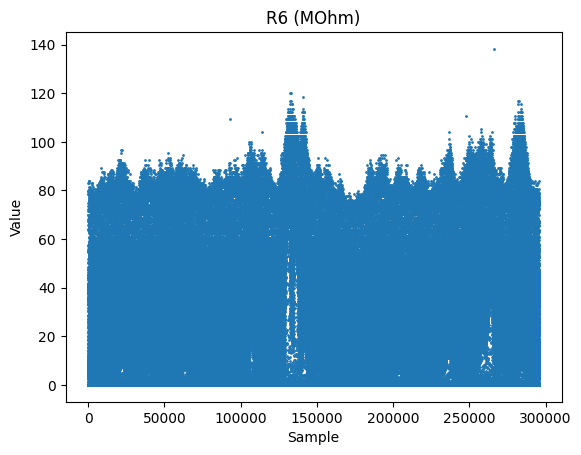

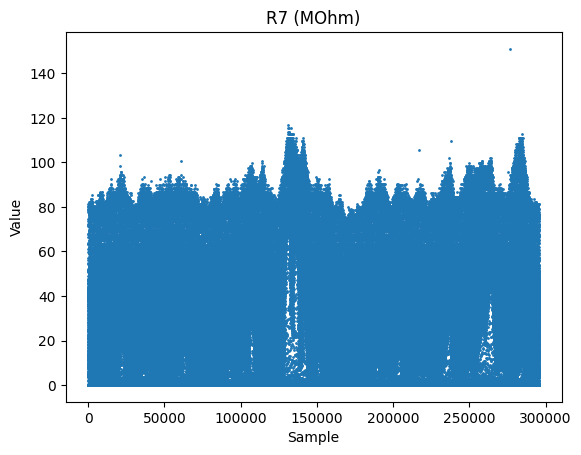

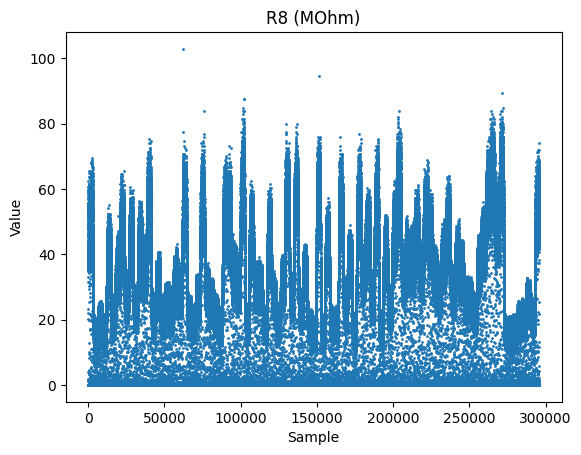

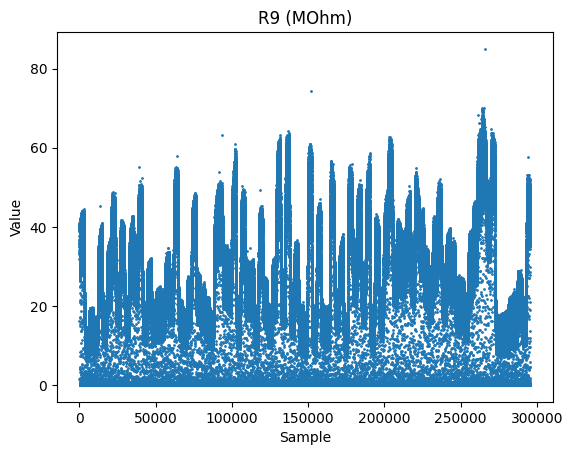

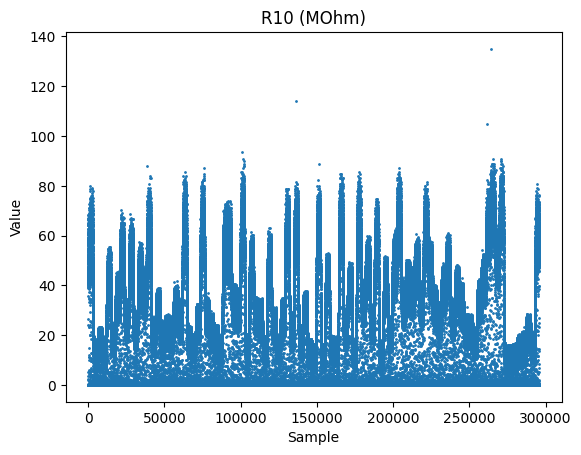

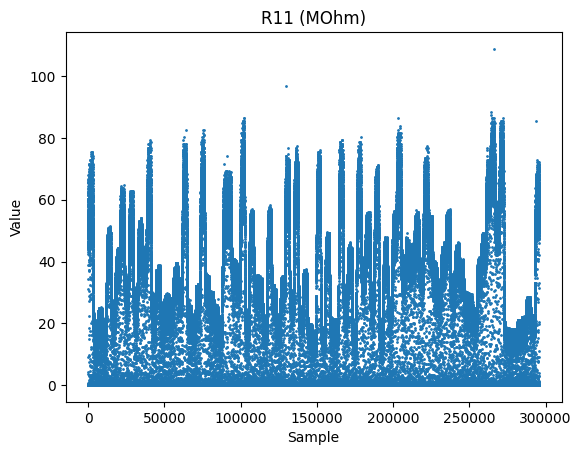

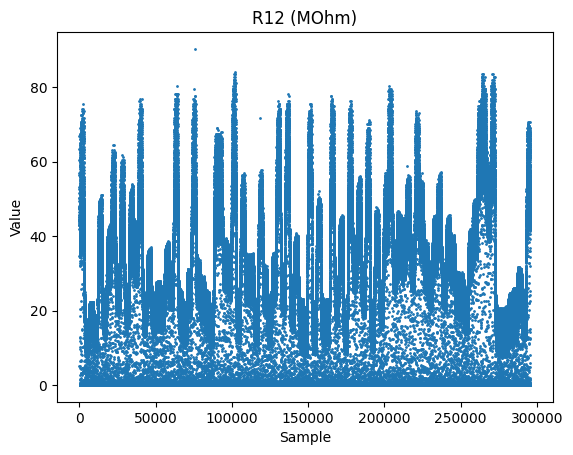

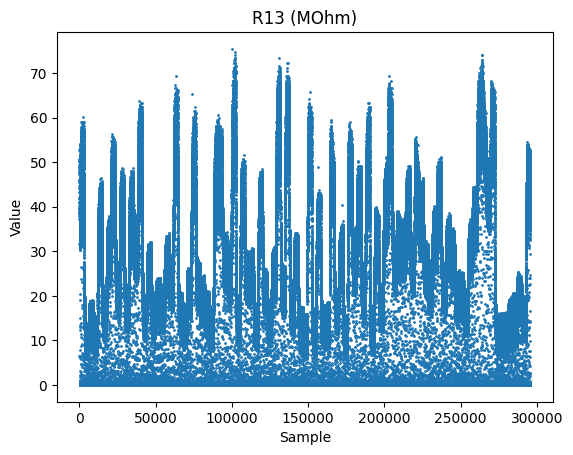

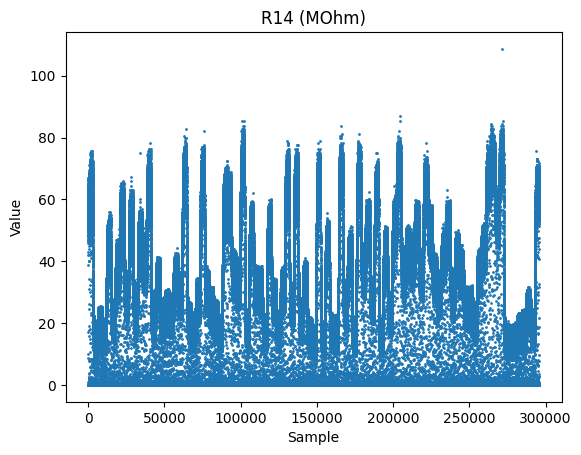

In [ ]:
for col in df.columns[6:]:
    # Create a scatter plot for the column
    plt.scatter(df.index, df[col], s=1)
    plt.title(col)
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.show()

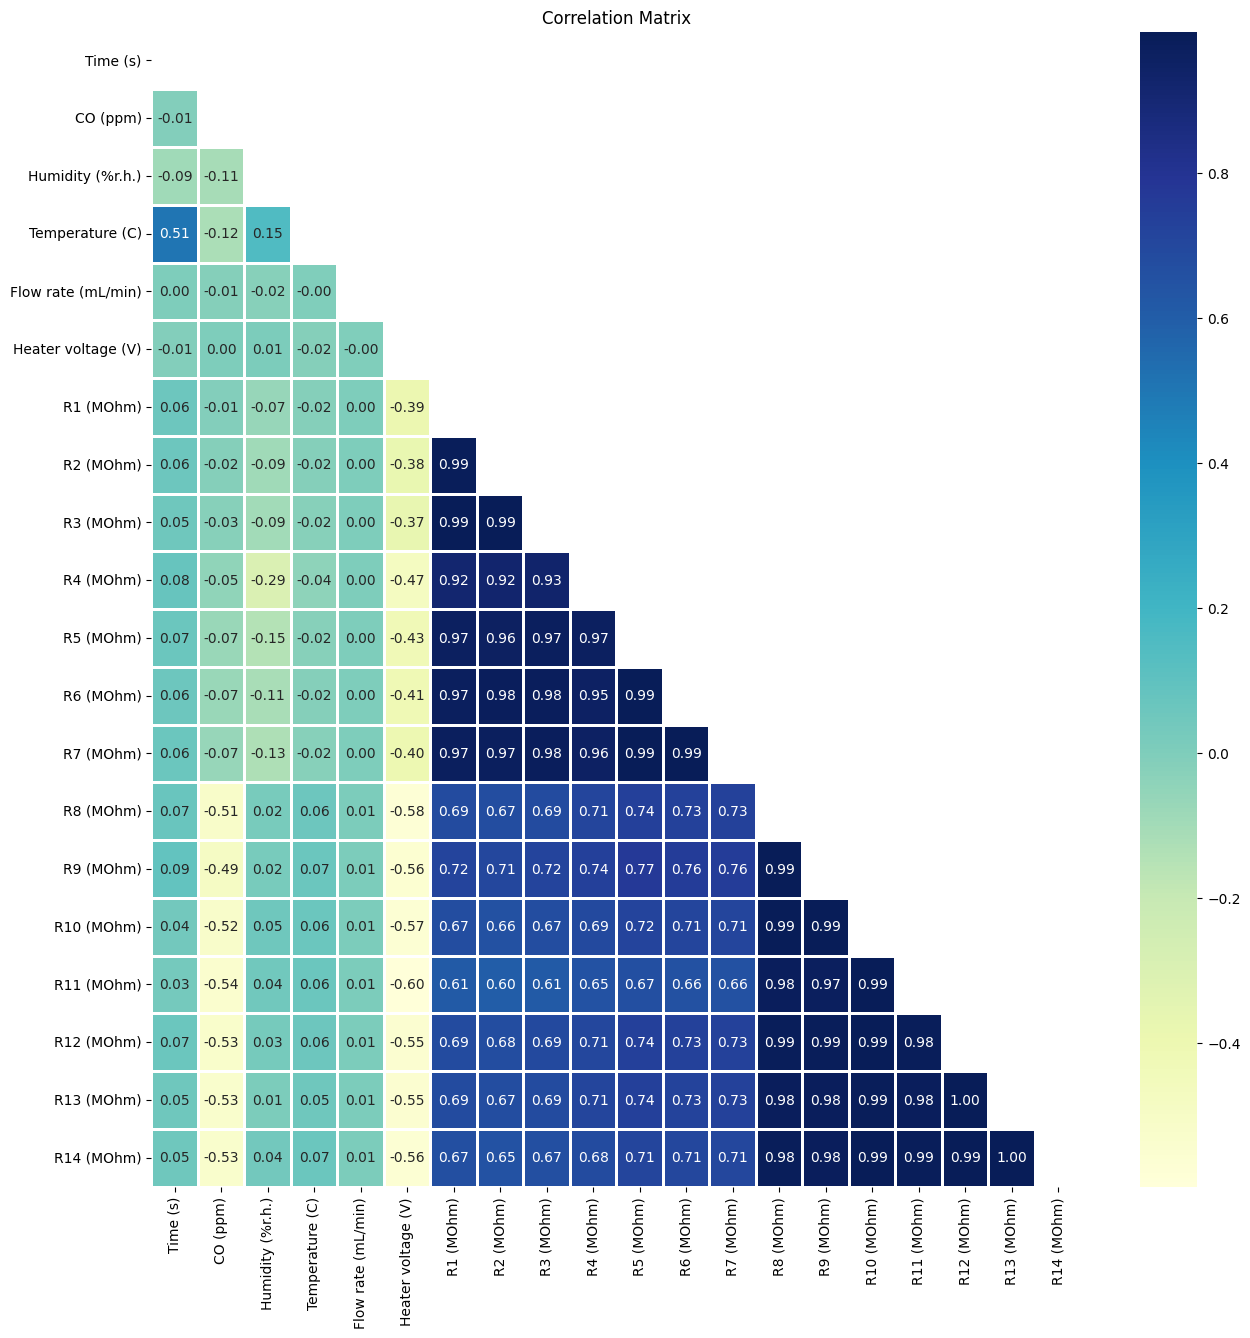

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".2f")
cormat.set_title('Correlation Matrix')
plt.show()

In [ ]:
class SensorDriftDetector:
    def __init__(self, A, H, Q, R, x0, P0):
        self.A = A
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self):
        # Predict the state estimate and error covariance estimate
        x_pred = self.A @ self.x
        P_pred = self.A @ self.P @ self.A.T + self.Q

        return x_pred, P_pred

    def update(self, z):
        # Compute the Kalman gain
        K = self.P @ self.H.T @ inv(self.H @ self.P @ self.H.T + self.R)

        # Update the state estimate and error covariance estimate
        self.x = self.x + K @ (z - self.H @ self.x)
        self.P = (np.eye(len(self.x)) - K @ self.H) @ self.P

    def detect_drift(self, z):
        # Predict the state estimate and error covariance estimate
        x_pred, P_pred = self.predict()

        # Update the state estimate and error covariance estimate
        self.update(z)

        # Compute the residual
        residual = z - self.H @ x_pred
        return np.linalg.norm(residual), self.H @ x_pred

In [ ]:
# Define the Kalman filter parameters
dt = 0.3  # time step
A = np.array([[1, dt], [0, 1]])  # state transition matrix
H = np.array([[1, 0]])  # observation matrix
Q = np.array([[1e-3, 0], [0, 1e-3]])  # process noise covariance matrix
R = np.array([[1e-1]])  # measurement noise covariance matrix
x0 = np.array([[0], [0]])  # initial state estimate
P0 = np.array([[1, 0], [0, 1]])  # initial error covariance estimate

# Create the Kalman filter object
kalman_filter = SensorDriftDetector(A, H, Q, R, x0, P0)

predicted_value = []
measured_value = []
# Loop over the rows of the dataset
for i in range(50000):
    # Get the sensor measurement vector
    z = np.array(df.iloc[i, 8:9])
    # Detect drift using the Kalman filter
    residual, predicted = kalman_filter.detect_drift(z)
    predicted_value.append(float(predicted))
    measured_value.append(z)
    # Check if drift has occurred
    # print(f"Drift detected in sample {i+1} with the predicted value of {float(predicted):.4f}, and the actual value of {float(z):.4f}")
    # if residual > 50 :
    #     print(f"Drift detected in sample {i+1} with residual {residual:.4f} and the predicted value of {float(predicted):.4f}, and the actual value of {float(z):.4f}")


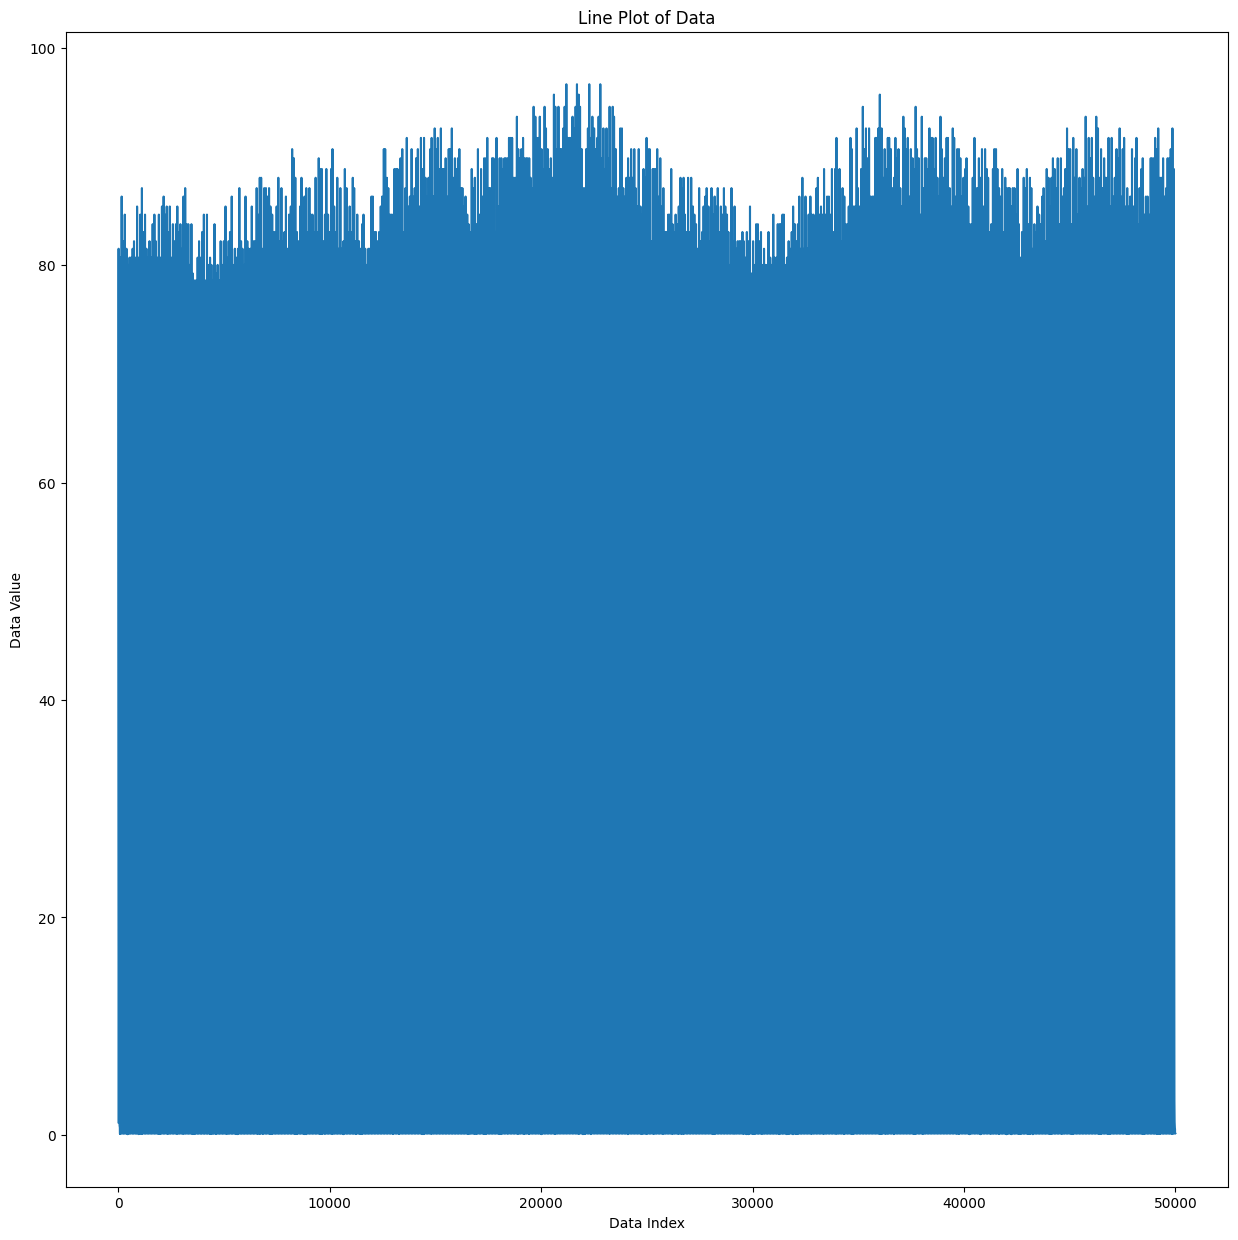

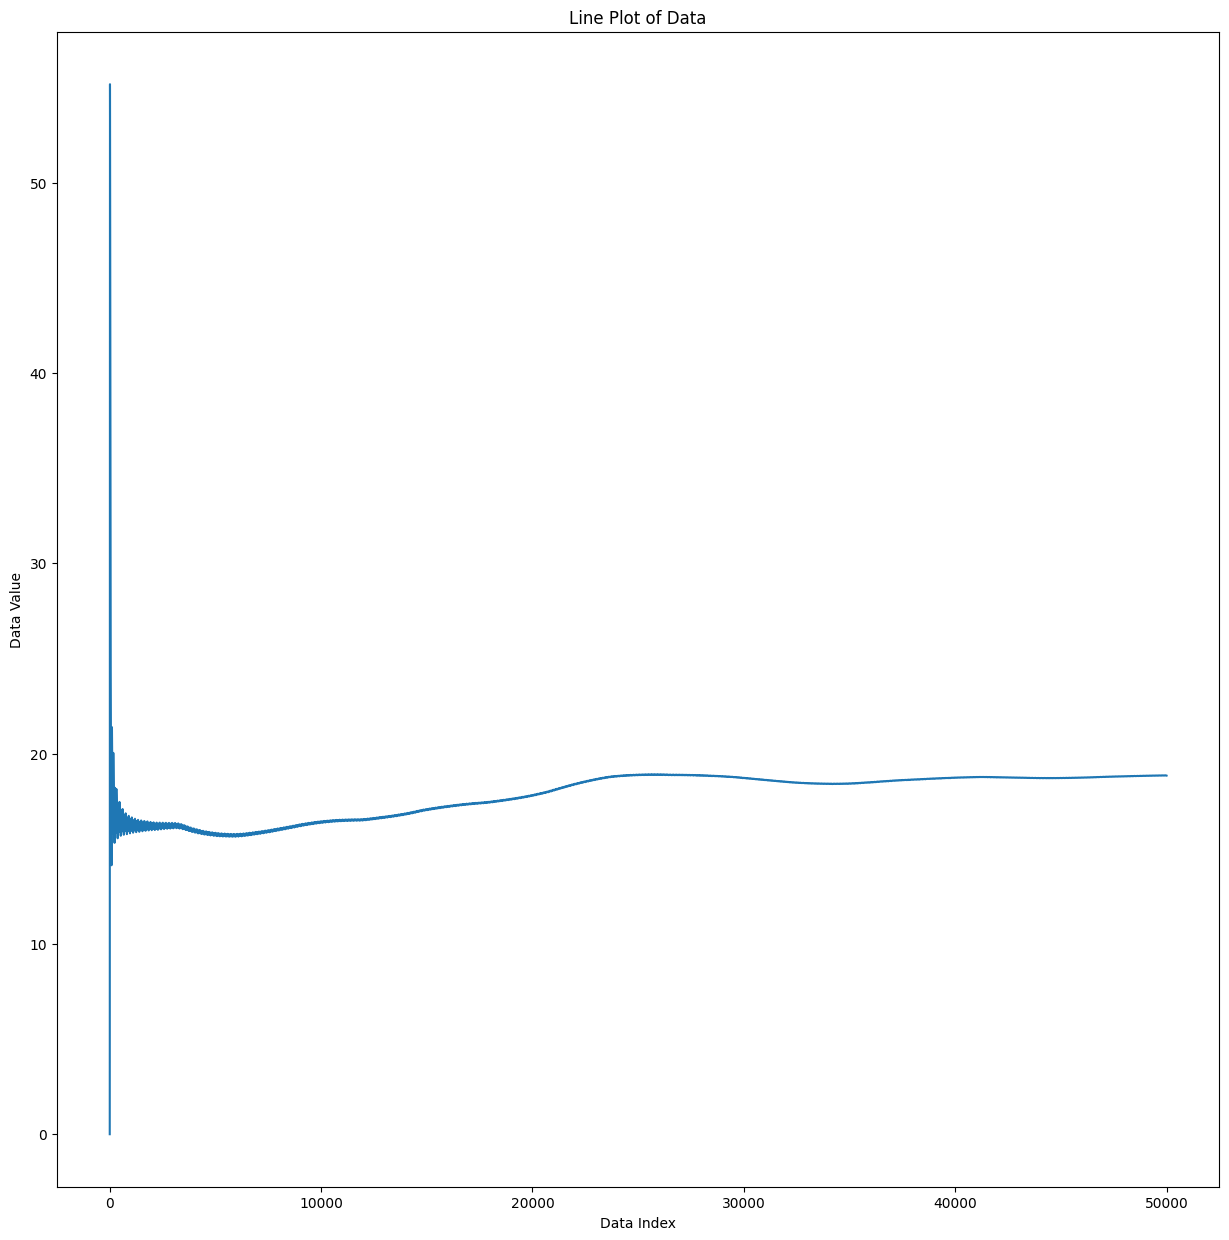

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(measured_value)
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

fig, ax = plt.subplots(figsize=(15,15))
ax.plot(predicted_value)
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

In [ ]:
dt = 0.01  # time step
F = np.array([[1, dt], [0, 1]])  # state transition matrix
H = np.array([[1, 0]])  # observation matrix
Q = np.array([[1e-3, 0], [0, 1e-3]])  # process noise covariance matrix
R = np.array([[1e-1]])  # measurement noise covariance matrix
x0 = np.array([[0], [0]])  # initial state estimate
P0 = np.array([[1, 0], [0, 1]])  # initial error covariance estimate

In [ ]:
# Generate synthetic data with drift
t = np.arange(0, 10, dt)
drift = 0.01 * t  # Linear drift
true_values = np.sin(t) + drift  # True values with drift
measurement_noise = np.sqrt(R) * np.random.randn(len(t))  # Measurement noise
measurements = true_values + measurement_noise.flatten()  # Measured values with noise
print(true_values.shape)

(1000,)


In [ ]:
# Initialize variables for Kalman filter estimation
x_est = np.zeros(1000)
P_est = np.zeros(1000)
residuals = np.zeros_like(t)

print(x_est.shape)

(1000,)


In [ ]:
# Run the Kalman filter
for i in range(len(t)):
    # Predict step
    x0 = F @ x0
    P0 = F @ P0 @ F.T + Q
    # Update step
    y = measurements[i] - H @ x0
    S = H @ P0 @ H.T + R
    K = P0 @ H.T / S
    x0 += K * y
    P0 -= K @ H @ P0
    x_est[i] = x0[0]
    P_est[i] = P0[0, 0]
    residuals[i] = y

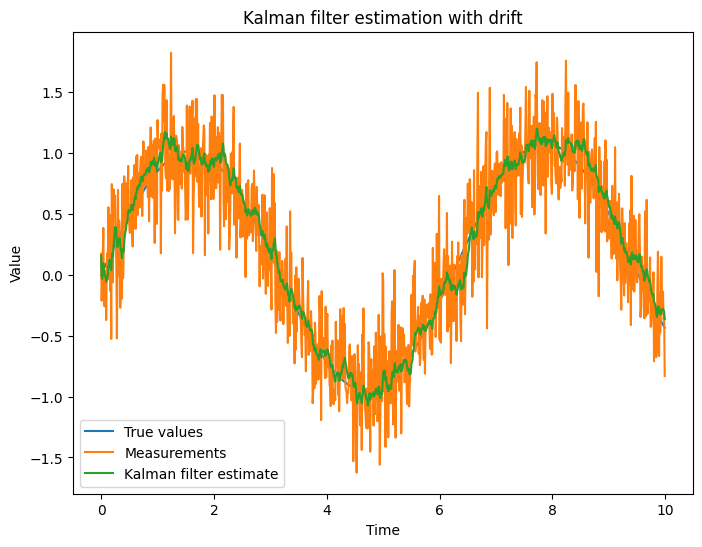

Drift detected at times: [0.04 0.06 0.09 0.13 0.15 0.16 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25
 0.27 0.28 0.29 0.3  0.31 0.34 0.35 0.36 0.37 0.38 0.39 0.41 0.42 0.43
 0.45 0.47 0.48 0.54 0.55 0.56 0.57 0.59 0.61 0.62 0.64 0.65 0.73 0.75
 0.83 0.85 0.88 0.89 0.92 0.95 0.96 0.98 0.99 1.   1.06 1.07 1.08 1.09
 1.1  1.12 1.14 1.15 1.16 1.17 1.2  1.22 1.24 1.25 1.26 1.27 1.31 1.32
 1.36 1.37 1.4  1.43 1.44 1.49 1.5  1.51 1.52 1.53 1.54 1.56 1.57 1.59
 1.61 1.62 1.63 1.64 1.66 1.68 1.7  1.71 1.73 1.74 1.75 1.76 1.78 1.82
 1.83 1.84 1.86 1.9  1.93 1.94 1.95 1.96 1.98 1.99 2.   2.01 2.04 2.07
 2.08 2.11 2.14 2.15 2.16 2.17 2.18 2.21 2.22 2.25 2.27 2.28 2.29 2.3
 2.32 2.34 2.35 2.36 2.37 2.4  2.43 2.46 2.47 2.48 2.52 2.53 2.56 2.57
 2.58 2.59 2.6  2.61 2.62 2.67 2.68 2.69 2.71 2.75 2.76 2.81 2.84 2.86
 2.87 2.9  2.91 2.92 2.94 2.96 2.99 3.02 3.03 3.06 3.08 3.09 3.1  3.12
 3.13 3.15 3.17 3.18 3.23 3.27 3.29 3.31 3.32 3.34 3.35 3.37 3.4  3.43
 3.44 3.45 3.46 3.48 3.5  3.55 3.56 3.57 3.63 3.66 3.

In [ ]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, true_values, label='True values')
plt.plot(t, measurements, label='Measurements')
plt.plot(t, x_est, label='Kalman filter estimate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Kalman filter estimation with drift')
plt.show()

# Check for drift by analyzing the residuals
drift_detected = np.abs(residuals) > 2 * np.sqrt(P_est)
if np.any(drift_detected):
    print('Drift detected at times:', t[drift_detected])
else:
    print('No drift detected')

In [ ]:
# Define the stationary period when no drift is expected
stationary_period_start = 0
stationary_period_end = 295719

for i in range(6,20):
    # Extract the sensor measurements for the first sensor
    sensor_measurements = df.iloc[:, i]
    # Calculate the standard deviation of the sensor measurements during the stationary period
    noise_level = np.std(sensor_measurements[stationary_period_start:stationary_period_end])
    print("Noise level for sensor : {:.4f}".format(noise_level))


In [ ]:
# Create a figure with subplots for each column
fig, axs = plt.subplots(nrows=len(df.columns)-1, figsize=(12,12))

# Loop over each column and create a histogram
for i, col in enumerate(df.columns[6:]):
    axs[i].hist(df[col], bins=50, color='blue')
    axs[i].set_title(col)
    axs[i].set_xlabel('Sensor Value')
    axs[i].set_ylabel('Frequency')

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.9)

# Show the plot
plt.show()

In [ ]:

# Create a boxplot of the dataset
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(df.iloc[:,6:], whis=1.5)
ax.set_xticklabels(df.columns[6:], rotation=45)
ax.set_ylabel('Sensor Value')
ax.set_title('Boxplot of Sensor Values')

# Show the plot
plt.show()

In [ ]:
# Read the file into a DataFrame
df = pd.read_csv('batch1.dat', header=None, sep=',')

# Get the dimensions of the DataFrame
rows, cols = df.shape
print(f"The dataset has {rows} rows and {cols} columns.")